C:\Users\harri\AppData\Local\Temp\ipykernel_27396\3919911591.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2018-01-01", end="2025-08-01")
[*********************100%***********************]  1 of 1 completed
c:\Users\harri\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
ANN with Indicators - RMSE: 4.52
ANN with Indicators - R² Score: 0.9613


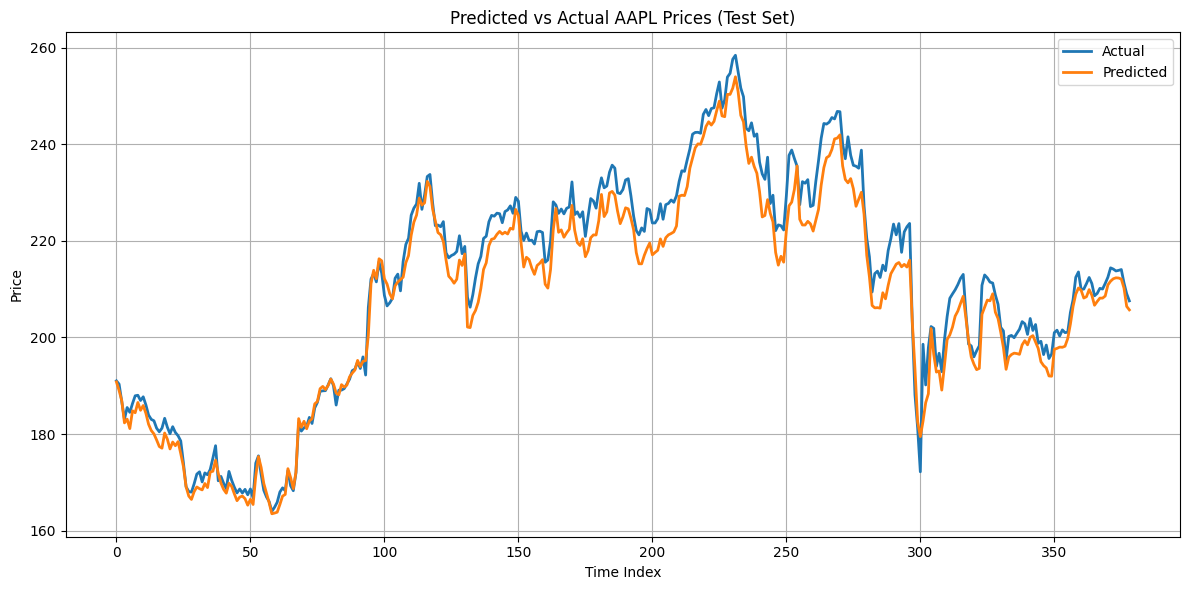

In [1]:
import os, random
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from ta.momentum import RSIIndicator

# Set random seeds for reproducibility
seed = 74
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)

# Download AAPL data with extended window
df = yf.download("AAPL", start="2018-01-01", end="2025-08-01")

# Ensure Close column is float and properly shaped
df['Close'] = df['Close'].astype(float)

# Add indicators safely
df['RSI'] = RSIIndicator(close=pd.Series(df['Close'].values.flatten(), index=df.index), window=14).rsi()
df['SMA_5'] = df['Close'].rolling(window=5).mean()

# Drop rows with NaNs from indicators
df.dropna(inplace=True)

# Check if we still have usable data
if df.empty:
    raise ValueError("DataFrame is empty after adding indicators and dropping NaNs.")

# Define features and target
features = ['Open', 'High', 'Low', 'Volume', 'RSI', 'SMA_5']
target = 'Close'
X = df[features].values
y = df[target].values.reshape(-1, 1)

# Normalize features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Train/test split
split = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y_scaled[:split], y_scaled[split:]

# Build the ANN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=16,
    callbacks=[early_stop],
    verbose=0  # set to 1 to show training logs
)

# Predict and reverse normalization
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)
print(f"ANN with Indicators - RMSE: {rmse:.2f}")
print(f"ANN with Indicators - R² Score: {r2:.4f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_actual, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linewidth=2)
plt.title("Predicted vs Actual AAPL Prices (Test Set)")
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("ann_predicted_vs_actual.png")
plt.show()


In [2]:
!pip install numpy pandas yfinance matplotlib scikit-learn tensorflow ta


  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl (12.9 MB)
  Using cached pandas-2.3.1-cp310-cp310-win_amd64.whl (11.3 MB)
  Using cached yfinance-0.2.65-py2.py3-none-any.whl (119 kB)
  Using cached matplotlib-3.10.5-cp310-cp310-win_amd64.whl (8.1 MB)
  Using cached scikit_learn-1.7.1-cp310-cp310-win_amd64.whl (8.9 MB)
  Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl (375.7 MB)
  Using cached ta-0.11.0-py3-none-any.whl
  Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
  Using cached beautifulsoup4-4.13.4-py3-none-any.whl (187 kB)
  Using cached websockets-15.0.1-cp310-cp310-win_amd64.whl (176 kB)
     -------------------------------------- 435.3/435.3 kB 3.0 MB/s eta 0:00:00
  Using cached peewee-3.18.2-py3-none-any.whl
  Using cached multitasking-0.0.12.tar.gz (19 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached curl_cffi-0.12.0-cp39-a

  DEPRECATION: multitasking is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
